In [1]:
# Chest X-ray Image Classification

In [2]:
#Load Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.utils import shuffle




In [3]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
2079,2079,person1271_virus_2164.jpeg,Pnemonia,TRAIN,NaN,Virus
4120,4120,person468_bacteria_1990.jpeg,Pnemonia,TRAIN,NaN,bacteria
3759,3759,person429_virus_877.jpeg,Pnemonia,TRAIN,NaN,Virus
478,478,IM-0620-0001-0002.jpeg,Normal,TRAIN,NaN,NaN
4246,4246,person580_bacteria_2387.jpeg,Pnemonia,TRAIN,NaN,bacteria


In [4]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(train_data.shape)
print(test_data.shape)
print(metadata.shape)
test_data.sample(5)

(5286, 6)
(624, 6)
(5910, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5416,5439,NORMAL2-IM-0282-0001.jpeg,Normal,TEST,NaN,NaN
5486,5509,NORMAL2-IM-0380-0001.jpeg,Normal,TEST,NaN,NaN
5498,5521,NORMAL2-IM-0364-0001.jpeg,Normal,TEST,NaN,NaN
5716,5739,person97_bacteria_468.jpeg,Pnemonia,TEST,NaN,bacteria
5761,5784,person81_bacteria_398.jpeg,Pnemonia,TEST,NaN,bacteria


In [5]:
# Generate the final train data from original train data with conditions refered from EDA inference
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(final_train_data.shape)
final_train_data.sample(30)

(1000, 7)


C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,target
305,305,IM-0487-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
662,662,NORMAL2-IM-0466-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
241,241,IM-0423-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
755,755,NORMAL2-IM-0587-0001-0002.jpeg,Normal,TRAIN,NaN,NaN,negative
599,599,NORMAL2-IM-0388-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1124,1124,NORMAL2-IM-1126-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1065,1065,NORMAL2-IM-1035-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
5272,5291,171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg,Pnemonia,TRAIN,COVID-19,Virus,positive
929,929,NORMAL2-IM-0842-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
638,638,NORMAL2-IM-0415-0001.jpeg,Normal,TRAIN,NaN,NaN,negative


In [6]:
from tensorflow.keras.metrics import *

#Load file & Create Model
train_data_dir = 'Coronahack-Chest-XRay-Dataset/train'
test_data_dir = 'Coronahack-Chest-XRay-Dataset/test'

epochs = 10

#metrics
metrics = [
    'accuracy',
    Precision(name='precision'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn')
]

model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=metrics)

#os.listdir(validation_data_dir)
#print(train_data_dir)
#print(validation_data_dir)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [7]:
# this is the augmentation configuration we will use for training
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_data_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_data_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=test_data_dir,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=8,
    class_mode=None
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(final_train_data)//8,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=len(final_validation_data)//8)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
125/125 [==============================] - 181s 1s/step - loss: 0.3934 - accuracy: 0.9570 - precision: 0.0000e+00 - tp: 0.0000e+00 - fp: 8.0000 - tn: 957.0000 - fn: 35.0000 - val_loss: 0.2201 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000
Epoch 2/10
125/125 [==============================] - 144s 1s/step - loss: 0.1843 - accuracy: 0.9650 - precision: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 965.0000 - fn: 35.0000 - val_loss: 0.1897 - val_accuracy: 0.9475 - val_precision: 1.0000 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 21.0000
Epoch 3/10
125/125 [==============================] - 159s 1s/step - loss: 0.1858 - accuracy: 0.9600 - precision: 0.0000e+00 - tp: 0.0000e+00 - fp: 5.0000 - tn: 960.0000 - fn: 35.0000 - val_loss: 0.1563 - val_accuracy: 0.9450 - val_precision: 1.0000 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 22.0000
Epoch 4/10
12

In [8]:
#model.save('initial_model.h5')

In [9]:
def plot_loss_acc(history):
    
    plt.figure(figsize=(14,6))
    plt.subplot2grid((1,2),(0,0))
    plt.plot(history.history['loss'], label = ('Train Loss'))
    plt.plot(history.history['val_loss'], label ='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot2grid((1,2),(0,1))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label ='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.show()

In [10]:
def classification_report(history):
    #Train report
    TP = history.history['tp'][-1] #True Positive
    FP = history.history['fp'][-1] #False Positif
    TN = history.history['tn'][-1] #True Negative
    FN = history.history['fn'][-1] #False Negatife

    confusion_matrix = np.matrix([[TP,FP],[FN,TN]])
    recall = 100*TP/(TP+FN)
    precision = 100*TP/(TP+FP)
    acc = history.history['accuracy'][-1]
    F_Measure = (2 * precision * recall) / (precision + recall)
    
    #Validation Report
    vTP = history.history['val_tp'][-1] #True Positive
    vFP = history.history['val_fp'][-1] #False Positif
    vTN = history.history['val_tn'][-1] #True Negative
    vFN = history.history['val_fn'][-1] #False Negatife

    val_confusion_matrix = np.matrix([[vTP,vFP],[vFN,vTN]])
    val_recall = 100*vTP/(vTP+vFN)
    val_precision = 100*vTP/(vTP+vFP)
    val_acc = history.history['val_accuracy'][-1]
    val_F_Measure = (2 * val_precision * val_recall) / (val_precision + val_recall)
    
    print('Training Report : \n')
    print('Confusion Matrix : \n', confusion_matrix,'\n')
    print('Recall : ', recall)
    print("Precision : ",precision)
    print('Accuracy : ', 100*acc)
    print('F-Measure : ', F_Measure)
    print('')
    print('Validation Report : \n')
    print('Confusion Matrix : \n', val_confusion_matrix,'\n')
    print('Recall : ', val_recall)
    print("Precision : ",val_precision)
    print('Accuracy : ', 100*val_acc)
    print('F-Measure : ', val_F_Measure)

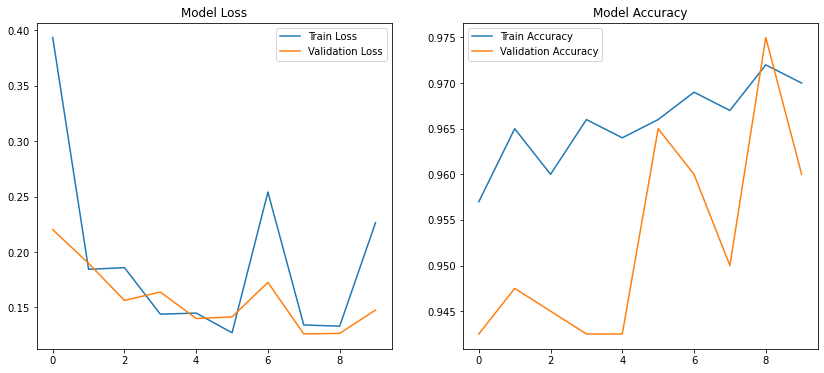

Training Report : 

Confusion Matrix : 
 [[ 11.   6.]
 [ 24. 959.]] 

Recall :  31.428571428571427
Precision :  64.70588235294117
Accuracy :  97.00000286102295
F-Measure :  42.30769230769231

Validation Report : 

Confusion Matrix : 
 [[  8.   1.]
 [ 15. 376.]] 

Recall :  34.78260869565217
Precision :  88.88888888888889
Accuracy :  95.99999785423279
F-Measure :  49.99999999999999


In [11]:
plot_loss_acc(history)
classification_report(history)